##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TensorFlow 2 quickstart for beginners

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/quickstart/beginner"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/quickstart/beginner.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This short introduction uses [Keras](https://www.tensorflow.org/guide/keras/overview) to:

1. Load a prebuilt dataset.
1. Build a neural network machine learning model that classifies images.
2. Train this neural network.
3. Evaluate the accuracy of the model.

This tutorial is a [Google Colaboratory](https://colab.research.google.com/notebooks/welcome.ipynb) notebook. Python programs are run directly in the browser—a great way to learn and use TensorFlow. To follow this tutorial, run the notebook in Google Colab by clicking the button at the top of this page.

1. In Colab, connect to a Python runtime: At the top-right of the menu bar, select *CONNECT*.
2. To run all the code in the notebook, select **Runtime** > **Run all**. To run the code cells one at a time, hover over each cell and select the **Run cell** icon.

![Run cell icon](images/beginner/run_cell_icon.png)

## Set up TensorFlow

Import TensorFlow into your program to get started:

In [16]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.15.0


If you are following along in your own development environment, rather than [Colab](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb), see the [install guide](https://www.tensorflow.org/install) for setting up TensorFlow for development.

Note: Make sure you have upgraded to the latest `pip` to install the TensorFlow 2 package if you are using your own development environment. See the [install guide](https://www.tensorflow.org/install) for details.

## Load a dataset

Load and prepare the MNIST dataset. The pixel values of the images range from 0 through 255. Scale these values to a range of 0 to 1 by dividing the values by `255.0`. This also converts the sample data from integers to floating-point numbers:

In [17]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

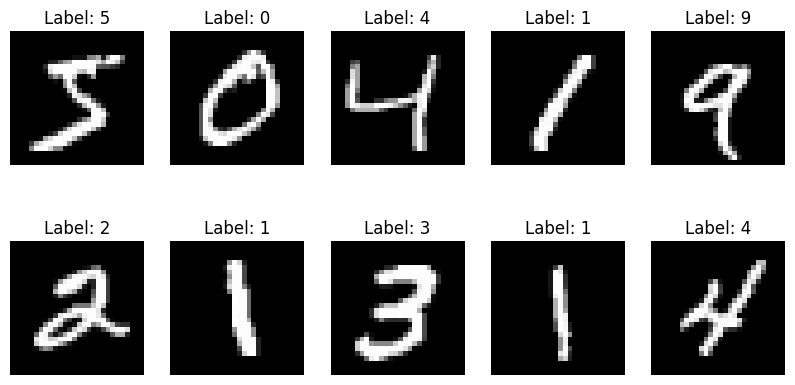

In [18]:
import matplotlib.pyplot as plt

# Display some images from the dataset
fig, axes = plt.subplots(2, 5, figsize=(10, 5))  # 2 rows, 5 columns

for i, ax in enumerate(axes.flat):
    ax.imshow(x_train[i], cmap='gray')
    ax.set_title(f"Label: {y_train[i]}")
    ax.axis('off')

plt.show()

In [19]:
x_train, x_test = x_train / 255.0, x_test / 255.0

## Build a machine learning model

Build a `tf.keras.Sequential` model:

In [20]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

[`Sequential`](https://www.tensorflow.org/guide/keras/sequential_model) is useful for stacking layers where each layer has one input [tensor](https://www.tensorflow.org/guide/tensor) and one output tensor. Layers are functions with a known mathematical structure that can be reused and have trainable variables. Most TensorFlow models are composed of layers. This model uses the [`Flatten`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten), [`Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense), and [`Dropout`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layers.

For each example, the model returns a vector of [logits](https://developers.google.com/machine-learning/glossary#logits) or [log-odds](https://developers.google.com/machine-learning/glossary#log-odds) scores, one for each class.

In [21]:
predictions = model(x_train[:1]).numpy()
predictions

array([[ 0.3604811 ,  0.35464334,  0.24841212,  0.05869923,  0.5810779 ,
         0.42614707,  0.685953  ,  0.06271818,  0.37920943, -0.3310071 ]],
      dtype=float32)

The `tf.nn.softmax` function converts these logits to *probabilities* for each class: 

In [22]:
tf.nn.softmax(predictions).numpy()

array([[0.10428346, 0.10367645, 0.0932276 , 0.07711755, 0.13002275,
        0.11136118, 0.14439963, 0.0774281 , 0.10625492, 0.05222831]],
      dtype=float32)

Note: It is possible to bake the `tf.nn.softmax` function into the activation function for the last layer of the network. While this can make the model output more directly interpretable, this approach is discouraged as it's impossible to provide an exact and numerically stable loss calculation for all models when using a softmax output. 

Define a loss function for training using `losses.SparseCategoricalCrossentropy`:

In [23]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

The loss function takes a vector of ground truth values and a vector of logits and returns a scalar loss for each example. This loss is equal to the negative log probability of the true class: The loss is zero if the model is sure of the correct class.

This untrained model gives probabilities close to random (1/10 for each class), so the initial loss should be close to `-tf.math.log(1/10) ~= 2.3`.

In [24]:
loss_fn(y_train[:1], predictions).numpy()

2.1949766

Before you start training, configure and compile the model using Keras `Model.compile`. Set the [`optimizer`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) class to `adam`, set the `loss` to the `loss_fn` function you defined earlier, and specify a metric to be evaluated for the model by setting the `metrics` parameter to `accuracy`.

In [25]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

## Train and evaluate your model

Use the `Model.fit` method to adjust your model parameters and minimize the loss: 

In [26]:
model.fit(x_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2970 - accuracy: 0.9127
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1443 - accuracy: 0.9566
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1101 - accuracy: 0.9672
Epoch 4/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0875 - accuracy: 0.9733
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0741 - accuracy: 0.9762


The `Model.evaluate` method checks the model's performance, usually on a [validation set](https://developers.google.com/machine-learning/glossary#validation-set) or [test set](https://developers.google.com/machine-learning/glossary#test-set).

In [27]:
model.evaluate(x_test,  y_test, verbose=2)

313/313 - 0s - loss: 0.0771 - accuracy: 0.9764 - 365ms/epoch - 1ms/step


[0.07712429016828537, 0.9764000177383423]

The image classifier is now trained to ~98% accuracy on this dataset. To learn more, read the [TensorFlow tutorials](https://www.tensorflow.org/tutorials/).

If you want your model to return a probability, you can wrap the trained model, and attach the softmax to it:

In [28]:
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

In [29]:
probability_model(x_test[:5])

<tf.Tensor: shape=(5, 10), dtype=float32, numpy=
array([[2.5661643e-07, 1.0490439e-09, 1.3079299e-06, 3.8270638e-04,
        7.0414979e-10, 4.6613817e-08, 2.5800827e-13, 9.9960500e-01,
        2.4860287e-07, 1.0462715e-05],
       [2.0847475e-08, 1.4288627e-05, 9.9997354e-01, 1.2131170e-05,
        3.4801484e-14, 7.8459763e-09, 2.8685273e-08, 1.5484131e-13,
        3.3761811e-08, 8.0159141e-15],
       [1.1422838e-07, 9.9872029e-01, 1.3009131e-04, 4.1887629e-06,
        4.7738489e-05, 4.3044611e-06, 3.4340878e-06, 8.4341143e-04,
        2.4608697e-04, 5.3439334e-07],
       [9.9896514e-01, 1.4321511e-10, 1.1858015e-04, 1.6053825e-06,
        4.7649846e-05, 2.1601392e-05, 1.6690989e-05, 1.3813378e-04,
        1.5965255e-06, 6.8908202e-04],
       [2.7834460e-05, 5.3823719e-08, 7.7965989e-05, 5.1751549e-06,
        9.5170116e-01, 6.6499756e-06, 1.1353291e-06, 2.2249768e-04,
        3.1189363e-06, 4.7954403e-02]], dtype=float32)>

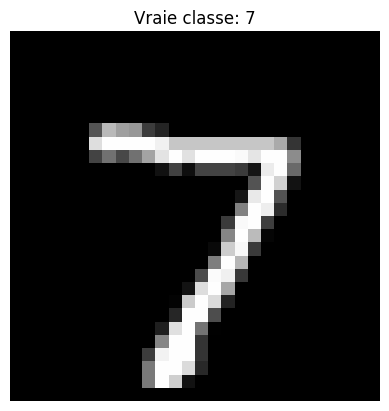

Classe prédite : 7


In [30]:
import numpy as np

# Sélection d'une image du jeu de test
index = 0  # Change cet index pour tester d'autres images
image = x_test[index]

# Affichage de l'image
plt.imshow(image, cmap='gray')
plt.title(f"Vraie classe: {y_test[index]}")
plt.axis('off')
plt.show()

# Prédiction du modèle
prediction = probability_model(np.expand_dims(image, axis=0))  # Ajouter une dimension batch
predicted_label = np.argmax(prediction)

print(f"Classe prédite : {predicted_label}")

## Conclusion

Congratulations! You have trained a machine learning model using a prebuilt dataset using the [Keras](https://www.tensorflow.org/guide/keras/overview) API.

For more examples of using Keras, check out the [tutorials](https://www.tensorflow.org/tutorials/keras/). To learn more about building models with Keras, read the [guides](https://www.tensorflow.org/guide/keras). If you want learn more about loading and preparing data, see the tutorials on [image data loading](https://www.tensorflow.org/tutorials/load_data/images) or [CSV data loading](https://www.tensorflow.org/tutorials/load_data/csv).
